In [29]:
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

In [30]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

# Define the paths to the training and validation directories
train_dir = 'data/PlantVillage/train'
validation_dir = 'data/PlantVillage/val'

# Load the training dataset from the 'train' folder
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

# Load the validation dataset from the 'val' folder
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    label_mode='categorical',
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 43444 files belonging to 38 classes.
Found 10861 files belonging to 38 classes.


## 2. Exploratory Data Analysis (EDA)

**Objective:** In this section, we will explore the PlantVillage dataset to understand its properties. We will check the class distribution to identify any imbalances and examine the dimensions of the images. This will help us make informed decisions during preprocessing and modeling.

### 2.1. Verify Image Loading & Display Samples

First, we confirm that the data has been loaded correctly by visualizing a sample of images and their corresponding labels from the training set.

Found 38 classes.
Class Names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_sp

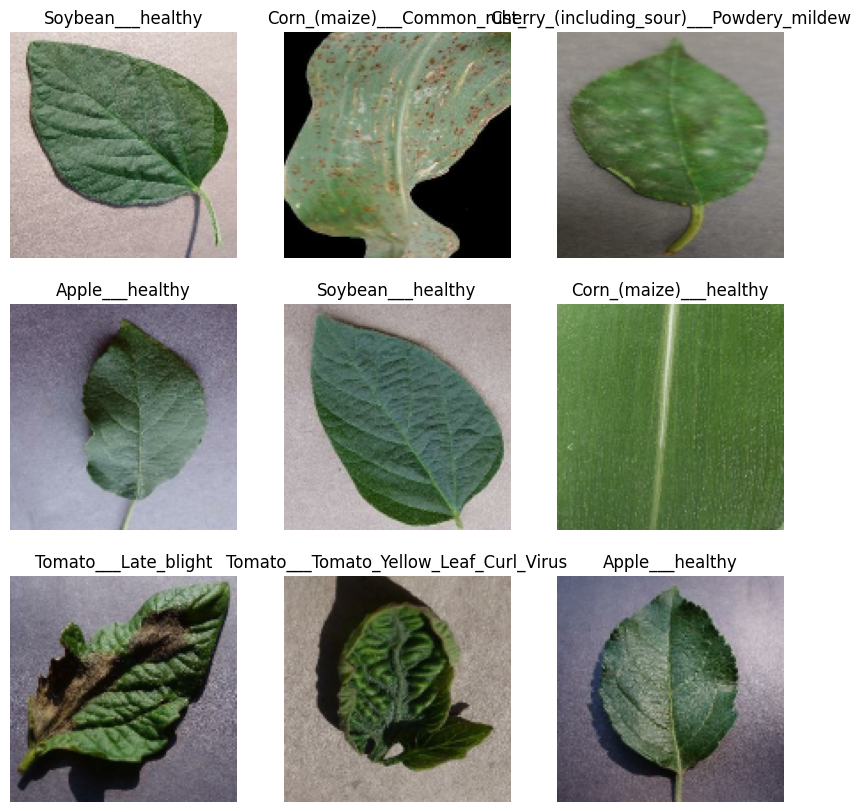

In [31]:
# Verify the data by plotting images
class_names = train_dataset.class_names
print(f"Found {len(class_names)} classes.")
print("Class Names:", class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(labels[i])])
    plt.axis("off")
plt.show()

### 2.2. Analyze Class Distribution

**Description:** We will now analyze the number of images per class. This is crucial to check for class imbalance, which can bias the model. A model trained on an imbalanced dataset might perform poorly on the minority classes. Here, we will introduce our first **reusable function** for plotting.

In [32]:

def plot_class_distribution(dataset, class_names, title):
    """
    Calculates and plots the distribution of classes in a tf.data.Dataset.
    
    Args:
      dataset (tf.data.Dataset): The dataset to analyze.
      class_names (list): A list of class names.
      title (str): The title for the plot.
    """
    # Get all the labels from the dataset
    labels = np.concatenate([y for x, y in dataset], axis=0)
    # The labels are one-hot encoded, so we get the index for each
    class_indices = np.argmax(labels, axis=1)
    
    # Count the occurrences of each class
    class_counts = np.bincount(class_indices)
    
    # Plotting
    plt.figure(figsize=(12, 8))
    sns.barplot(x=class_names, y=class_counts)
    plt.title(title, fontsize=16)
    plt.ylabel("Number of Images", fontsize=12)
    plt.xlabel("Class", fontsize=12)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

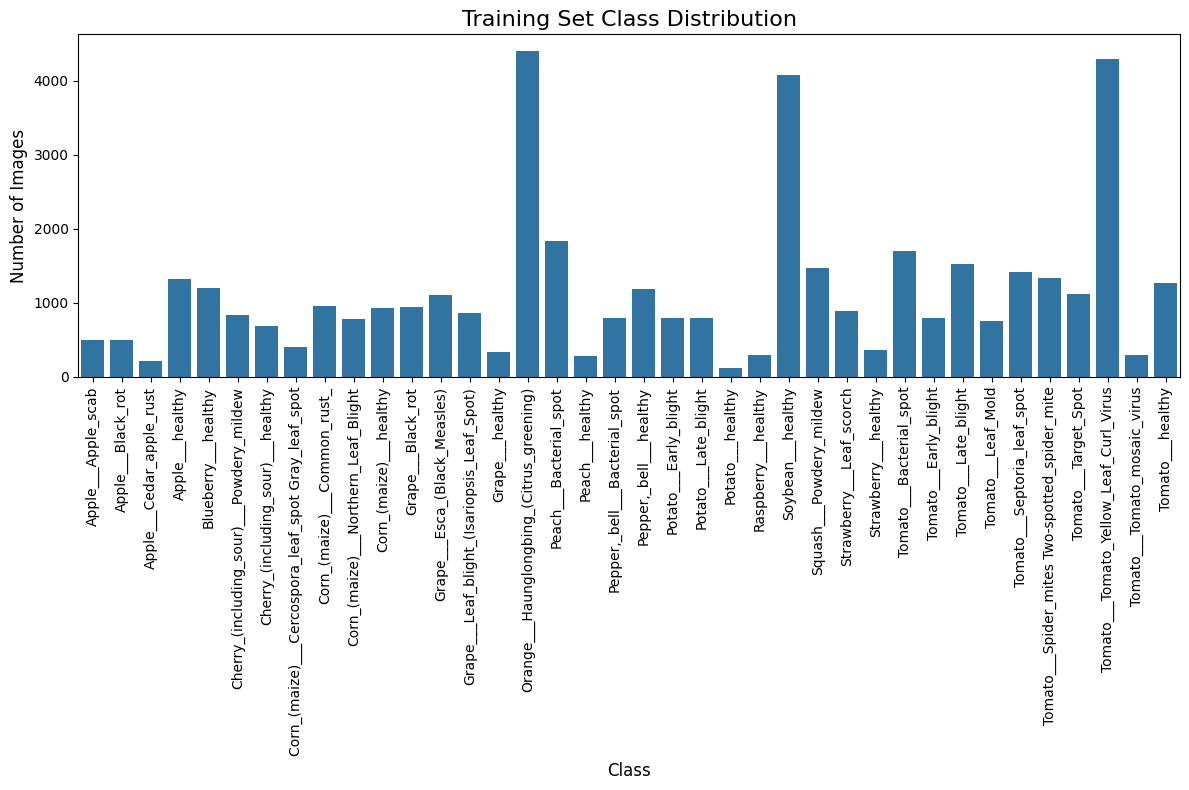

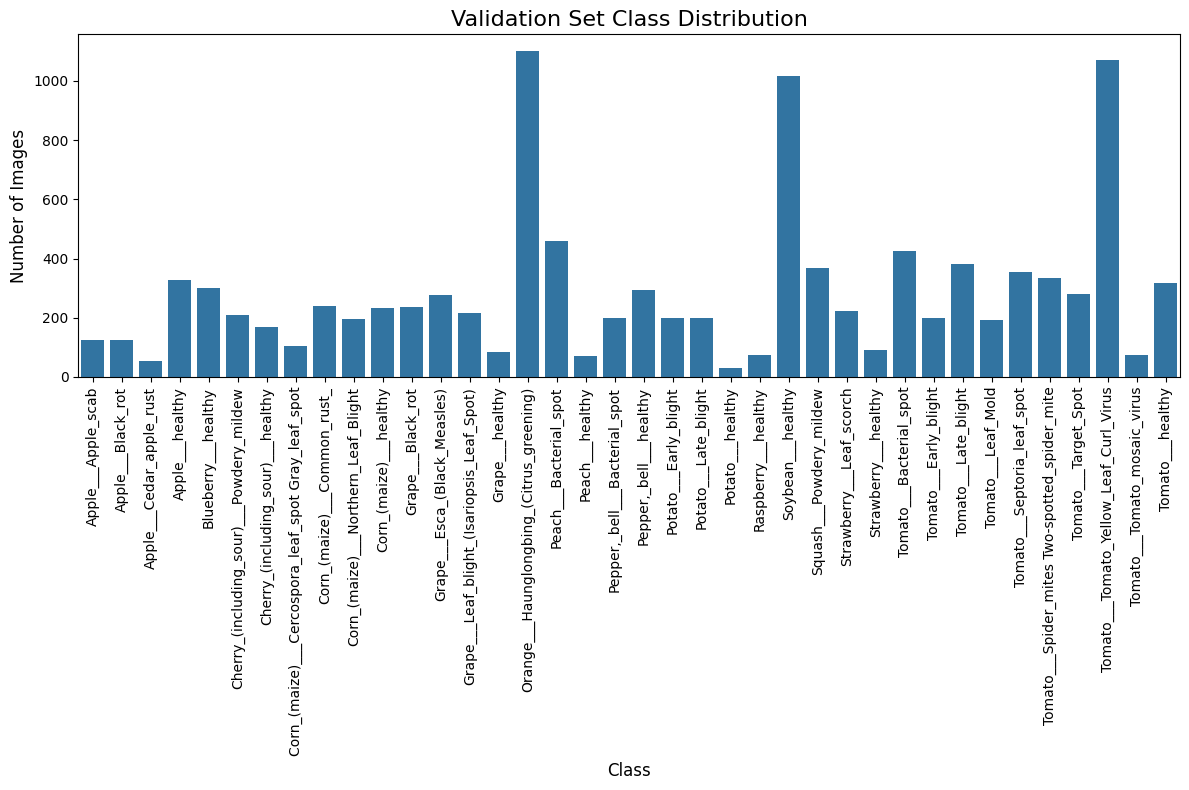

In [33]:
# Plot the class distribution for both training and validation datasets
plot_class_distribution(train_dataset, class_names, "Training Set Class Distribution")
plot_class_distribution(validation_dataset, class_names, "Validation Set Class Distribution")

### 2.3. Distributions Observations


* The plots for both the training and validation sets clearly show that the dataset is **imbalanced**. The number of images varies significantly across the different classes.

* There are a few majority classes with a very large number of images. Specifically:
    * `Orange___Haunglongbing_(Citrus_greening)`
    * `Raspberry___healthy`
    * `Tomato___Target_Spot`
    * These classes each have over 4,000 images in the training set.

* Conversely, there are several minority classes with far fewer images. For example, classes like `Apple___Cedar_apple_rust` and `Grape___Esca_(Black_Measles)` have under 1,000 images each.

* The validation set shows the same distribution pattern as the training set, which is good. It confirms that our random split was representative of the overall dataset.

**Implication for the Project:**

This imbalance is a critical finding. A model trained on this data might become biased towards the majority classes. It could achieve high accuracy by simply learning to predict the most common diseases well, while performing poorly on the rarer diseases. We will need to keep this in mind during training and may need to use techniques like **data augmentation** or **class weighting** to help the model pay more attention to the minority classes.

## 3. Data Preprocessing & Final Splitting

### 3.1. Create Final Test Set

**Description:** To properly evaluate our final model, we need a test dataset that is never used during training or hyperparameter tuning. We must have separate training, validation, and test datasets. We will create our test set by splitting our current `validation_dataset` into two halves.

In [34]:
def split_dataset(dataset, split_ratio=0.5):
    """
    Splits a tf.data.Dataset into two smaller datasets.
    
    Args:
      dataset (tf.data.Dataset): The dataset to be split.
      split_ratio (float): The ratio for the first split (e.g., 0.5 for a 50/50 split).
      
    Returns:
      A tuple containing the two new datasets.
    """
    # Get the dataset size and convert it to a regular number with .numpy()
    dataset_size = tf.data.experimental.cardinality(dataset).numpy()

    # Calculate the number of elements for the first split
    split_count = int(dataset_size * split_ratio)
    
    split_1 = dataset.take(split_count)
    split_2 = dataset.skip(split_count)
    
    return split_1, split_2

In [35]:
# Split the validation dataset into two equal parts: new validation and test datasets
test_dataset, validation_dataset = split_dataset(validation_dataset, split_ratio=0.5)

print('Number of batches in the new validation set: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of batches in the new test set: %d' % tf.data.experimental.cardinality(test_dataset))

Number of batches in the new validation set: 170
Number of batches in the new test set: 170
